# Stream Processing with Kafka and Spark  

This Notebook sets up a complete Stream Processing Lab in Google Colab, inclduing a single broker Kafka cluster, AVRO-based Kafka Producer, AVRO-based Kafka Consumer and Spark Structure Streaming jobs consuming AVRO records from Kafka.  

In [1]:
!pip install --quiet Faker fastavro kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 16.7 MB/s eta 0:00:00


# Kafka Setup *

In [2]:
%%writefile environment.sh
#!/usr/bin/bash
export KAFKA_BINARY_VERSION='3.7.0'
export SCALA_BINARY_VERSION='2.13'
export KAFKA_BINARY_VERSION=$KAFKA_BINARY_VERSION
export SCALA_BINARY_VERSION=$SCALA_BINARY_VERSION
export PATH=$PATH:$PWD/kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION/bin

Writing environment.sh


In [3]:
%%writefile kafka_setup.sh

source ./environment.sh
echo kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION
echo $PATH

# Java Setup
wget -O- https://apt.corretto.aws/corretto.key | sudo apt-key add -
sudo add-apt-repository 'deb https://apt.corretto.aws stable main' -y
sudo apt-get -y update; sudo apt-get install -y java-11-amazon-corretto-jdk

# Kafka Setup
wget https://downloads.apache.org/kafka/${KAFKA_BINARY_VERSION}/kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}.tgz
tar xzf kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}.tgz

UUID=$(./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-storage.sh random-uuid)
echo "export UUID=$UUID" >> ./environment.sh
cat environment.sh

# Start Kafka Broker

echo kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION

# offsets.retention.minutes determines how long Kafka retains the commit offsets for consumer groups.
echo "offsets.retention.minutes=300" >> ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties

./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-storage.sh format -t ${UUID} -c ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties
nohup ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-server-start.sh ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties > kafka_server.log &

Writing kafka_setup.sh


In [4]:
%%shell
source kafka_setup.sh
sleep 10
tail -20 kafka_server.log

kafka_2.13-3.7.0
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/kafka_2.13-3.7.0/bin
--2024-04-14 09:41:25--  https://apt.corretto.aws/corretto.key
Resolving apt.corretto.aws (apt.corretto.aws)... 52.84.18.24, 52.84.18.105, 52.84.18.14, ...
Connecting to apt.corretto.aws (apt.corretto.aws)|52.84.18.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1695 (1.7K) [binary/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.66K  --.-KB/s    in 0s      

2024-04-14 09:41:25 (687 MB/s) - written to stdout [1695/1695]

OK
Repository: 'deb https://apt.corretto.aws stable main'
Description:
Archive for codename: stable components: main
More info: https://apt.corretto.aws
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/archive_uri-https_apt_corretto_aws-jammy.list
Adding disabled deb-src entry to /etc/apt/s

Create a topic "spotifywrapped" with 3 partitions and replication factor of 1:

In [5]:
%%shell

source ./environment.sh

# Delete the existing Kafka topic
#kafka-topics.sh --bootstrap-server 127.0.0.1:9092 --topic spotifywrapped --delete

# Recreate the Kafka topic with the desired configuration
kafka-topics.sh --bootstrap-server 127.0.0.1:9092 --topic spotifywrapped --create --partitions 3 --replication-factor 1


Created topic spotifywrapped.


Inspect consumer groups

In [6]:
%%writefile check_kafka_consumers.sh
#!/usr/bin/env bash
source ./environment.sh

echo "Active Consumer Groups"
while true
do
date
kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --describe --all-groups
sleep 1
done


Writing check_kafka_consumers.sh


In [7]:
%%shell
chmod +x ./check_kafka_consumers.sh
nohup ./check_kafka_consumers.sh > kafka_consumers.log &

nohup: redirecting stderr to stdout


# Kafa Producer of Spotify AVRO Records *

In [8]:
%%writefile avro_producer.py
import numpy as np
from datetime import datetime, timedelta
import fastavro
from fastavro import parse_schema
import pandas as pd
from kafka import KafkaProducer
import io
import random

from faker import Faker
fake = Faker()
Faker.seed(2000)

spotify = pd.read_csv('/content/spotifywrapped.csv')

schema = {
    "doc": "spotify_wrapped",
    "name": "spotify_wrapped_schema",
    "type": "record",
    "fields": [
        {"name": "user", "type": "string"},
        {"name": "timestamp", "type": "long"},
        {"name": "song_id", "type": "string"},
        {"name": "song_name", "type": "string"},
        {"name": "genre", "type": "string"},
        {"name": "artists", "type": "string"},
        {"name": "duration_ms", "type": "int"}
    ]
}
parsed_schema = parse_schema(schema)


def simulate_user_activity(start_time: str, end_time: str, genres: list, songs_df: pd.DataFrame = spotify) -> None:
    # Generate a random user name
    name = fake.name()

    # Parse start and end times into datetime objects
    start_time = datetime.fromisoformat(start_time)
    end_time = datetime.fromisoformat(end_time)

    # Generate random timestamps and select a random number of songs per day within the specified time frame
    while start_time < end_time:
        # Randomly select the number of songs for the day (between 5 and 50)
        n_songs = random.randint(5, 50)

        # Randomly select songs from specified genres
        selected_songs = songs_df[songs_df['genre'].isin(genres)].sample(n=n_songs, replace=True)

        # Write Avro records for each selected song
        user_data = []
        for _, song in selected_songs.iterrows():
          start_time = start_time + timedelta(seconds=np.random.randint(30, 86400))
          avro_record = {
              'user': name,
              'timestamp': int(start_time.timestamp() * 1000),  # Convert to milliseconds
              'song_id': song['song_id'],
              'genre': song['genre'],
              'song_name': song['song_name'],  # Corrected from 'trackName' to 'song_name'
              'artists': song['artists'],
              'duration_ms': song['duration_ms']
              }
        user_data.append(avro_record)

        # Move to the next day
        start_time += timedelta(days=1)

    return user_data

def simulate_spotify_data(start_time: str, end_time: str, genres_list: list, file_name: str = 'multiple_users.avro') -> None:
    user_data = []
    for i, genres in enumerate(genres_list, start=1):
        user = simulate_user_activity(start_time, end_time, genres)
        user_data.extend(user)  # Use extend to add all elements of user to user_data

    # with open(file_name, 'wb') as out:
    #     # Ensure user_data is a list of dictionaries
    #     writer(out, parsed_schema, user_data)
    # print("Users' data saved in file:", file_name)
    return user_data

def serialize(message):
  print("Serialize:" + str(message))
  schemaless_bytes_writer = io.BytesIO()
  fastavro.schemaless_writer(schemaless_bytes_writer, schema, message)
  return schemaless_bytes_writer.getvalue()



producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],
    value_serializer=serialize
)

import sys
topic_name_default="spotifywrapped"
if len(sys.argv) > 1:
  topic_name = sys.argv[1]
else:
  topic_name = topic_name_default

# generating 1 year of data for 150 users
start_time = '2024-01-01T00:00:00+00:00'
end_time = '2025-01-01T00:00:00+00:00'

def user_generation(n_users=150):
    genres = [["indie pop", "indie rock", "alternative rock", "folk-pop"],
              ["hip hop", "rap", "trap", "dfw rap"],
              ["pop", "dance pop", "electropop", "synth-pop"],
              ["electronica", "edm", "house", "techno"],
              ["classic rock", "alternative metal", "punk", "grunge"]]
    all_preferences = []
    for i in range(n_users):
        all_preferences.append(random.choice(genres))
    return all_preferences

messages = simulate_spotify_data(start_time, end_time, user_generation())
pd.DataFrame(messages).to_csv('/content/spotify_analysis.csv') # for analysis!
for message in messages:
    print(message)
    producer.send(topic_name, value=message)

# Flush the producer
producer.flush()


Writing avro_producer.py


The producer is sent to the background as it will produce records over a long period of time

In [9]:
!nohup python /content/avro_producer.py > /content/avro_producer.log &

nohup: redirecting stderr to stdout


Observe the producer's log for a few seconds. Then, interrupt the cell execution.

In [10]:
!sleep 5
!tail -20 /content/avro_producer.log

# Python Kafka Consumer setup *

In [11]:
%%writefile avro_consumer.py


# Import the required modules
from kafka import KafkaConsumer
import fastavro
import io

# Define the schema for the records
schema = {
    "doc": "spotify_wrapped",
    "name": "spotify_wrapped_schema",
    "type": "record",
    "fields": [
        {"name": "user", "type": "string"},
        {"name": "timestamp", "type": "long"},
        {"name": "song_id", "type": "string"},
        {"name": "song_name", "type": "string"},
        {"name": "genre", "type": "string"},
        {"name": "artists", "type": "string"},
        {"name": "duration_ms", "type": "int"}
    ]
}

# Parse the updated schema
from fastavro import parse_schema
parsed_updated_schema = parse_schema(schema)

# Create a Kafka producer with value serializer
def deserialize(message):
  # print("Deserialize:" + str(message))

  import io
  schemaless_bytes_reader = io.BytesIO(message)
  try:
    record=fastavro.schemaless_reader(schemaless_bytes_reader, schema)
    return record
  except Exception as ex:
    print(ex)
    return "pass"

# Create a Kafka consumer with value deserializer
# topic name is a command line argument, if not present it defaults to weather
import sys
topic_name_default="spotifywrapped"
if len(sys.argv) > 1:
  topic_name = sys.argv[1]
else:
  topic_name = topic_name_default

consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='Python_AVRO_Consumer',
    value_deserializer=deserialize #lambda v: fastavro.schemaless_reader(io.BytesIO(v), schema)
)

# Consume messages from the topic and print them
for message in consumer:
    print("="*10)
    print(message.value)


Writing avro_consumer.py


Observe how the AVRO consumer receives the messages from the Kafka topic. After a few seconds, interrupt the cell execution:

In [12]:
!nohup python avro_consumer.py > avro_consumer.log &

nohup: redirecting stderr to stdout


In [13]:
!sleep 5
!tail -20 avro_consumer.log

In [14]:
!ps -ef |grep avro

root        6551       1  2 09:42 ?        00:00:00 python3 avro_consumer.py
root        6992     185  0 09:43 ?        00:00:00 /bin/bash -c ps -ef |grep avro
root        6994    6992  0 09:43 ?        00:00:00 grep avro


In [15]:
%%shell
source ./environment.sh
kafka-consumer-groups.sh --bootstrap-server localhost:9092 --list

Python_AVRO_Consumer


In [16]:
%%shell

source ./environment.sh
kafka-consumer-groups.sh --bootstrap-server localhost:9092 --describe --group Python_AVRO_Consumer


GROUP                TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID                                             HOST            CLIENT-ID
Python_AVRO_Consumer spotifywrapped  0          36              36              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  1          49              49              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  2          65              65              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2


In [17]:
!tail -20 kafka_consumers.log

Python_AVRO_Consumer spotifywrapped  1          -               49              -               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  2          -               65              -               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Sun Apr 14 09:43:02 AM UTC 2024

GROUP                TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID                                             HOST            CLIENT-ID
Python_AVRO_Consumer spotifywrapped  0          36              36              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  1          49              49              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  2   

In [18]:
%%shell

source ./environment.sh
kafka-consumer-groups.sh --bootstrap-server localhost:9092 --describe --all-groups


GROUP                TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID                                             HOST            CLIENT-ID
Python_AVRO_Consumer spotifywrapped  0          36              36              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  1          49              49              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer spotifywrapped  2          65              65              0               kafka-python-2.0.2-6cc618a3-403e-4661-b190-a81167306d4b /127.0.0.1      kafka-python-2.0.2


# Spark Setup

Reference: https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html

In [19]:
spark_release='spark-3.5.1'
hadoop_version='hadoop3'

import os, time
start=time.time()
os.environ['SPARK_RELEASE']=spark_release
os.environ['HADOOP_VERSION']=hadoop_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_release}-bin-{hadoop_version}"

In [20]:
# Run below commands in google colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # install Java8
!wget -q http://apache.osuosl.org/spark/${SPARK_RELEASE}/${SPARK_RELEASE}-bin-${HADOOP_VERSION}.tgz # download spark-3.3.X
!tar xf ${SPARK_RELEASE}-bin-${HADOOP_VERSION}.tgz # unzip it

!pip install -q findspark # install findspark
# findspark find your Spark Distribution and sets necessary environment variables

import findspark
findspark.init()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.5.1


# Define the configuration details for your Spark job:


Create your Spark session. You must define details of the Kafka Cluster to connect to, topic name and consumer group name.

- kafka_brokers: List of Kafka bootstrap servers  
- topic_name: The Kafka topic to read messages from
- consumer_group: This allows you to use different Spark jobs to consume the same topic messages and implement different analytics
- schema: the AVRO schema of topic messages

In [21]:
kafka_brokers="127.0.0.1:9092" # Can be a comma-separated list of brokers
topic_name="spotifywrapped"

# Define the AVRO schema as a string
schema = """
{
    "doc": "spotify_wrapped",
    "name": "spotify_wrapped_schema",
    "type": "record",
    "fields": [
        {"name": "user", "type": "string"},
        {"name": "timestamp", "type": "long"},
        {"name": "song_id", "type": "string"},
        {"name": "song_name", "type": "string"},
        {"name": "genre", "type": "string"},
        {"name": "artists", "type": "string"},
        {"name": "duration_ms", "type": "int"}
    ]
}
"""


In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.avro.functions import from_avro

# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("StreamingAVROFromKafka") \
    .config("spark.streaming.stopGracefullyOnShutdown", "true") \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.1,org.apache.spark:spark-avro_2.12:3.5.1') \
    .config("spark.sql.shuffle.partitions", "4") \
    .master("local[*]") \
    .getOrCreate()


In [23]:
# Kafka Configuration for reading from Kafka/Event Hub
# Kafka source will create a unique group id for each query automatically. The user can set the prefix of the automatically
# generated group.id’s via the optional source option groupIdPrefix, default value is “spark-kafka-source”.
kafkaConf = {
    "kafka.bootstrap.servers": kafka_brokers,
    # Below settins required if kafka is secured:
    # "kafka.sasl.mechanism": "PLAIN",
    # "kafka.security.protocol": "SASL_SSL",
    # "kafka.sasl.jaas.config": 'org.apache.kafka.common.security.plain.PlainLoginModule required username="$ConnectionString" password="Endpoint=sb://eventhubname.servicebus.windows.net/;SharedAccessKeyName=listenpolicyforspark;SharedAccessKey=ckNkSjcyXKGN8FCIRIS3qtkKvW+AEhB6QPaM=;EntityPath=instructortest";',
    "subscribe": topic_name, # to read from specific partitions use option: "assign": {topic_name:[0,1]})
    "startingOffsets": "earliest", # "earliest", "latest"
    "enable.auto.commit": "true ",
    "groupIdPrefix": "Stream_Analytics_",
    "auto.commit.interval.ms": "5000"
}


# Read from Event Hub using Kafka
df = spark \
    .readStream \
    .format("kafka") \
    .options(**kafkaConf)

In [24]:
df = df.load()  # Start reading data from the specified Kafka topic

In [25]:
df

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [26]:
# Deserialize the AVRO messages from the value column
df = df.select(from_avro(df.value, schema).alias("spotifywrapped"))

# Print the schema of the DataFrame
df.printSchema()

root
 |-- spotifywrapped: struct (nullable = true)
 |    |-- user: string (nullable = false)
 |    |-- timestamp: long (nullable = false)
 |    |-- song_id: string (nullable = false)
 |    |-- song_name: string (nullable = false)
 |    |-- genre: string (nullable = false)
 |    |-- artists: string (nullable = false)
 |    |-- duration_ms: integer (nullable = false)



##!!!!

In [27]:
from pyspark.sql.functions import col

# Assuming df is your DataFrame containing the AVRO record after flattening
df = df.select(
    col("spotifywrapped.user").alias("user"),
    col("spotifywrapped.timestamp").alias("event_timestamp"),
    col("spotifywrapped.song_id").alias("song_id"),
    col("spotifywrapped.song_name").alias("song_name"),
    col("spotifywrapped.genre").alias("genre"),
    col("spotifywrapped.artists").alias("artists"),
    col("spotifywrapped.duration_ms").alias("duration_ms")
)

df.printSchema()


root
 |-- user: string (nullable = true)
 |-- event_timestamp: long (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- duration_ms: integer (nullable = true)



In [28]:
from pyspark.sql.functions import col

# Assuming df is your DataFrame containing the event_timestamp column
df = df.withColumn("event_timestamp", col("event_timestamp").cast("timestamp"))

# Verify the data types
df.printSchema()

root
 |-- user: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- duration_ms: integer (nullable = true)



# Analytical Queries

Your Spark job and input messages are ready to be worked on. Now, you can apply any transformations required to answer business questions.    

In [29]:
# @title
!mkdir checkpoint

In [30]:
# Create a Spark Session

spark = SparkSession.builder \
    .appName("Analytical Queries") \
    .getOrCreate()

### **Query 1:** Top 3 artists, genres, and songs per user:

In [75]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, udf
from pyspark.sql.types import ArrayType, StringType


# Aggregate the artists, genres, and songs for each user into lists
grouped_df = df.groupBy("user").agg(
    collect_list("artists").alias("all_artists"),
    collect_list("genre").alias("all_genres"),
    collect_list("song_name").alias("all_songs")
)

# Define a custom aggregation function to select the top items for each user
def select_top_items(items_list):
    sorted_items = sorted(items_list, key=lambda x: -items_list.count(x))
    return list(dict.fromkeys(sorted_items[:1]))

# Define the UDFs (User Defined Functions) for artists, genres, and songs
select_top_udf = udf(select_top_items, ArrayType(StringType()))

# Apply the UDFs to select the top artist, genre, and song for each user
top_df = grouped_df.select(
    col("user"),
    select_top_udf(col("all_artists")).alias("top_artist"),
    select_top_udf(col("all_genres")).alias("top_genre"),
    select_top_udf(col("all_songs")).alias("top_song")
)

# Write the results to console as a streaming query
query_name = 'topArtistGenreSong'
query = top_df \
    .writeStream \
    .outputMode("update") \
    .format("memory") \
    .queryName(query_name) \
    .start()

time.sleep(300)

query.stop()

In [76]:
from time import sleep

# Function to display the contents periodically
def display_streaming_results(query_name, interval_seconds=10, iterations=5):
    """
    Displays the streaming query results periodically.

    Parameters:
    query_name (str): The name of the in-memory table to query.
    interval_seconds (int): How long to wait between each display.
    iterations (int): How many times to display the results.
    """
    for _ in range(iterations):
        results_df = spark.table(query_name)
        results_df.show(truncate=False)
        sleep(interval_seconds)

# Assuming 'topArtistGenreSong2' is the name of your in-memory table
display_streaming_results("topArtistGenreSong", interval_seconds=30, iterations=1)


+-----------------+---------------+-------------------+------------------------------------------------+
|user             |top_artist     |top_genre          |top_song                                        |
+-----------------+---------------+-------------------+------------------------------------------------+
|Brianna Barrett  |[Lauv]         |[pop]              |[Modern Loneliness]                             |
|Aaron Flores     |[Lauv]         |[pop]              |[Summer Nights]                                 |
|Hannah Ross      |[WILD]         |[folk-pop]         |[Here We Go]                                    |
|Elizabeth Mayer  |[Post Malone]  |[dfw rap]          |[I Like You (A Happier Song) (with Doja Cat)]   |
|Maria Webb       |[Tommy Lefroy] |[indie pop]        |[Trashfire]                                     |
|Teresa Washington|[Linkin Park]  |[alternative metal]|[Leave Out All The Rest]                        |
|Marisa Robinson  |[LULLANAS]     |[folk-pop]         |

In [77]:
from pyspark.sql.functions import count

def aggregate_top_choices(query_name, sleep_time=10, iterations=5):
    """
    Aggregates and displays the top choices from streaming data periodically.

    Parameters:
    query_name (str): The name of the in-memory table to query.
    sleep_time (int): Seconds to wait between each query.
    iterations (int): Number of times to query and display results.
    """
    for _ in range(iterations):
        # Read the latest snapshot of the streaming data from the in-memory table
        results_df = spark.table(query_name)

        # Aggregate to find the most common top artists, genres, and songs
        top_artists = results_df.groupBy("top_artist").agg(count("top_artist").alias("count_artist")).orderBy(col("count_artist").desc()).limit(3)
        top_genres = results_df.groupBy("top_genre").agg(count("top_genre").alias("count_genre")).orderBy(col("count_genre").desc()).limit(3)
        top_songs = results_df.groupBy("top_song").agg(count("top_song").alias("count_song")).orderBy(col("count_song").desc()).limit(3)

        # Display the results
        print("Top Artists:")
        top_artists.show(truncate=False)
        print("Top Genres:")
        top_genres.show(truncate=False)
        print("Top Songs:")
        top_songs.show(truncate=False)

        sleep(sleep_time)

aggregate_top_choices("topArtistGenreSong", sleep_time=30, iterations=1)


Top Artists:
+-------------+------------+
|top_artist   |count_artist|
+-------------+------------+
|[Linkin Park]|16          |
|[Post Malone]|9           |
|[NF]         |8           |
+-------------+------------+

Top Genres:
+-------------------+-----------+
|top_genre          |count_genre|
+-------------------+-----------+
|[pop]              |25         |
|[edm]              |24         |
|[alternative metal]|21         |
+-------------------+-----------+

Top Songs:
+--------------------------------------+----------+
|top_song                              |count_song|
+--------------------------------------+----------+
|[Renegade]                            |4         |
|[Plain Jane REMIX (feat. Nicki Minaj)]|3         |
|[Queen of Disaster]                   |3         |
+--------------------------------------+----------+



In [78]:
# Convert table to DF
top_df = spark.sql("SELECT * FROM topArtistGenreSong")

# Save df
top_df = top_df.toPandas()
top_df.to_csv('top_artist_genre_song.csv', index=False)

###**Query 2:** Peak Listening Times
- When users are most actively listening to music

In [35]:
from pyspark.sql.functions import window, col, count

# Directly use 'event_timestamp' as it's already a timestamp type for windowing:
peak_listening_times = df \
    .groupBy(
        window(col("event_timestamp"), "1 hour")
    ) \
    .agg(
        count("*").alias("plays")
    ) \
    .orderBy("window.start")  # Ordering by the start of the window


In [36]:
query = peak_listening_times \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("peakListeningTimesTable") \
    .start()

sleep(60)

In [37]:
# Now query the in-memory table
display_df = spark.sql("SELECT * FROM peakListeningTimesTable")
display_df.show(truncate=False)

# Remember to stop the stream after you're done to free resources
query.stop()

+----------------------------------------------+-----+
|window                                        |plays|
+----------------------------------------------+-----+
|{+56969-02-13 21:00:00, +56969-02-13 22:00:00}|1    |
|{+56969-07-19 11:00:00, +56969-07-19 12:00:00}|1    |
|{+56969-09-15 16:00:00, +56969-09-15 17:00:00}|1    |
|{+56969-09-16 23:00:00, +56969-09-17 00:00:00}|1    |
|{+56969-10-19 11:00:00, +56969-10-19 12:00:00}|1    |
|{+56970-02-02 17:00:00, +56970-02-02 18:00:00}|1    |
|{+56970-02-23 19:00:00, +56970-02-23 20:00:00}|1    |
|{+56970-04-01 16:00:00, +56970-04-01 17:00:00}|1    |
|{+56970-08-07 19:00:00, +56970-08-07 20:00:00}|1    |
|{+56970-11-09 16:00:00, +56970-11-09 17:00:00}|1    |
|{+56970-12-14 16:00:00, +56970-12-14 17:00:00}|1    |
|{+56971-04-09 07:00:00, +56971-04-09 08:00:00}|1    |
|{+56971-05-30 22:00:00, +56971-05-30 23:00:00}|1    |
|{+56971-08-29 01:00:00, +56971-08-29 02:00:00}|1    |
|{+56971-10-17 16:00:00, +56971-10-17 17:00:00}|1    |
|{+56971-1

In [42]:
from pyspark.sql.functions import hour, date_format

# Load the data from the in-memory table
peak_times_df = spark.sql("SELECT * FROM peakListeningTimesTable")

# Extract hour from the window start time and aggregate to find the most common peak hours
most_common_hours = peak_times_df.withColumn("hour", hour(col("window.start"))) \
    .groupBy("hour") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

# Show the results
most_common_hours.show(truncate=False)


+----+-----+
|hour|count|
+----+-----+
|16  |10   |
|10  |10   |
|12  |8    |
|22  |8    |
|2   |8    |
|11  |8    |
|18  |7    |
|23  |7    |
|3   |7    |
|17  |6    |
|19  |6    |
|15  |6    |
|20  |6    |
|6   |6    |
|5   |6    |
|1   |6    |
|0   |6    |
|8   |6    |
|9   |5    |
|21  |5    |
+----+-----+
only showing top 20 rows



***Interpretation:***
- Most common hours: 4pm and 10pm
- Evening and late night trends: at times like 10pm (22) and 11pm (23), suggest there is activity late in the evening, potentially as people relax or unwind before bed.
- Morning hours (10 & 11) and mid-afternoon hours (16) - key times when users are active on the platform, potentially during breaks or commutes.


In [45]:
from pyspark.sql.functions import hour

# Extract hour and prepare the DataFrame
hourly_counts = spark.sql("""
SELECT hour(window.start) AS hour, sum(plays) as count
FROM peakListeningTimesTable
GROUP BY hour(window.start)
ORDER BY hour(window.start)
""")

# Convert to Pandas DataFrame for plotting
pandas_df = hourly_counts.toPandas()


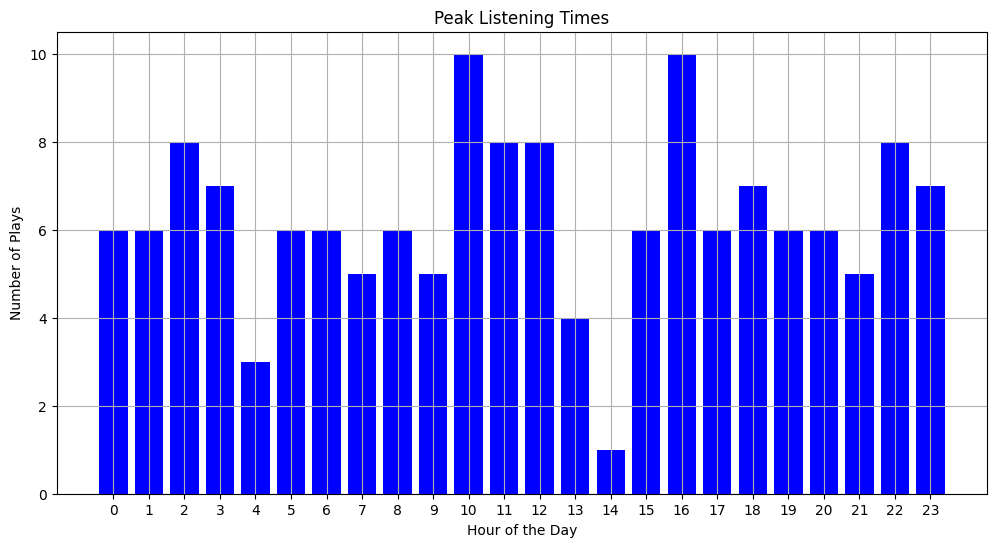

In [46]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['hour'], pandas_df['count'], color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Plays')
plt.title('Peak Listening Times')
plt.xticks(pandas_df['hour'])  # Ensure x-ticks represent each hour correctly
plt.grid(True)
plt.show()

In [73]:
# Save the DataFrame to a CSV file
pandas_df.to_csv('peak_times_df.csv', index=False)

### **Query 3:** User Genre Preferences Over Time
- Calculates weekly counts of song plays per genre for each user and stores results in an in-memory table.
- Handles late data with a 7-day watermark.

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col, count
import time

df_with_watermark = df.withWatermark("event_timestamp", "7 days")

user_genre_preferences = df_with_watermark.groupBy(
    col("user"),
    window(col("event_timestamp"), "1 week"),
    col("genre")
).agg(count("song_id").alias("song_plays"))

query = user_genre_preferences \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("user_genre_preferences_table") \
    .start()

time.sleep(300)

In [39]:
def display_sorted_results():
    sorted_df = spark.sql("""
        SELECT user, window, genre, song_plays
        FROM user_genre_preferences_table
        ORDER BY user, window.start, song_plays DESC
    """)
    sorted_df.show(truncate=False)

# Display results after waiting
display_sorted_results()

# Stop the query after checking the output
query.stop()

+-----------------+----------------------------------------------+-----------------+----------+
|user             |window                                        |genre            |song_plays|
+-----------------+----------------------------------------------+-----------------+----------+
|Aaron Flores     |{+56978-09-24 00:00:00, +56978-10-01 00:00:00}|pop              |1         |
|Aaron Robinson   |{+56976-10-10 00:00:00, +56976-10-17 00:00:00}|dance pop        |1         |
|Adam Horn        |{+56984-08-19 00:00:00, +56984-08-26 00:00:00}|hip hop          |1         |
|Adam Velazquez   |{+56969-10-19 00:00:00, +56969-10-26 00:00:00}|indie pop        |1         |
|Alan Martinez    |{+56970-02-22 00:00:00, +56970-03-01 00:00:00}|alternative metal|1         |
|Alyssa Evans DDS |{+56997-05-25 00:00:00, +56997-06-01 00:00:00}|electropop       |1         |
|Alyssa Jones     |{+56990-10-21 00:00:00, +56990-10-28 00:00:00}|alternative metal|1         |
|Amanda Russell   |{+56979-09-23 00:00:0

In [50]:
overall_genre_popularity = spark.sql("""
    SELECT genre, SUM(song_plays) AS total_plays
    FROM user_genre_preferences_table
    GROUP BY genre
    ORDER BY total_plays DESC
""")

# Display overall genre popularity
overall_genre_popularity.show(truncate=False)

+-----------------+-----------+
|genre            |total_plays|
+-----------------+-----------+
|pop              |25         |
|edm              |24         |
|alternative metal|21         |
|folk-pop         |14         |
|indie pop        |14         |
|hip hop          |13         |
|dfw rap          |10         |
|dance pop        |8          |
|alternative rock |8          |
|classic rock     |4          |
|electropop       |2          |
|indie rock       |2          |
|trap             |2          |
|electronica      |2          |
|grunge           |1          |
+-----------------+-----------+



In [71]:
# Save df
weekly_data = overall_genre_popularity.toPandas()
weekly_data.to_csv('weekly_genre_trends.csv', index=False)

***Interpretation***
- Pop - most popular genre throughout the year (25 plays)
- EDM - closely follows (24 plays)
- Alternative metal - (21 plays)
- Niche genres like Electropop, Indie Rock, and Electronica have fewer plays - suggest more specific audience segments

In [55]:
from pyspark.sql.functions import col, month, count

# Modify the DataFrame to group by month, and sum the song plays per genre
monthly_genre_trends = df_with_watermark.groupBy(
    month(col("event_timestamp")).alias("month"),
    col("genre")
).agg(count("song_id").alias("total_plays"))

# Start the stream to write the aggregated data to an in-memory table
query_monthly = monthly_genre_trends \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("monthly_genre_trends_table3") \
    .start()

# Allow some time for data to accumulate
time.sleep(300)  # Adjust based on your environment

# Query and display the results from the in-memory table
monthly_trends_df = spark.sql("""
    SELECT month, genre, total_plays
    FROM monthly_genre_trends_table
    ORDER BY month, total_plays DESC
""")
monthly_trends_df.show(truncate=False)

# Stop the stream after checking the output
query_monthly.stop()

+-----+-----------------+-----------+
|month|genre            |total_plays|
+-----+-----------------+-----------+
|1    |dance pop        |1          |
|1    |pop              |1          |
|1    |alternative rock |1          |
|1    |indie pop        |1          |
|1    |edm              |1          |
|1    |edm              |1          |
|1    |alternative rock |1          |
|2    |alternative metal|1          |
|2    |dfw rap          |1          |
|2    |pop              |1          |
|2    |hip hop          |1          |
|2    |alternative metal|1          |
|2    |alternative metal|1          |
|2    |folk-pop         |1          |
|2    |alternative metal|1          |
|2    |pop              |1          |
|2    |pop              |1          |
|2    |indie rock       |1          |
|2    |dfw rap          |1          |
|2    |edm              |1          |
+-----+-----------------+-----------+
only showing top 20 rows



In [61]:
static_df = spark.sql("SELECT month, genre, total_plays FROM monthly_genre_trends_table ORDER BY month, total_plays DESC")

# Convert to Pandas DataFrame for further analysis
monthly_trends_pd = static_df.toPandas()

# Get the top genre per month using Pandas
top_genre_per_month = monthly_trends_pd.groupby('month').apply(lambda x: x.nlargest(1, 'total_plays')).reset_index(drop=True)

# Display the Pandas DataFrame
print(top_genre_per_month)

    month              genre  total_plays
0       1          dance pop            1
1       2                pop            1
2       3  alternative metal            1
3       4                edm            2
4       5                edm            1
5       6  alternative metal            1
6       7                edm            1
7       8                pop            2
8       9                pop            1
9      10  alternative metal            1
10     11           folk-pop            1
11     12  alternative metal            1


In [65]:
import pandas as pd

top_genre_per_month = pd.DataFrame({
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'genre': [
        'dance pop', 'pop', 'alternative metal', 'edm', 'edm',
        'alternative metal', 'edm', 'pop', 'pop', 'alternative metal',
        'folk-pop', 'alternative metal'
    ],
    'total_plays': [1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1]
})

# Map the month number to the month name for better readability
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
             5: 'May', 6: 'June', 7: 'July', 8: 'August',
             9: 'September', 10: 'October', 11: 'November', 12: 'December'}
top_genre_per_month['month'] = top_genre_per_month['month'].map(month_map)

# Reorder the DataFrame based on the month
top_genre_per_month = top_genre_per_month.set_index('month').sort_index()

# For visual display in Jupyter Notebook, we can use the display function
display(top_genre_per_month)


,genre,total_plays
month,,
April,edm,2
August,pop,2
December,alternative metal,1
February,pop,1
January,dance pop,1
July,edm,1
June,alternative metal,1
March,alternative metal,1
May,edm,1


In [70]:
# Save the DataFrame to a CSV file
monthly_trends_pd.to_csv("monthly_genre_trends.csv", index=True, header=True)

In [ ]:
# @title
# Get the list of active streaming queries
active_queries = spark.streams.active

# Check if there are any active queries
if not active_queries:
    print("No active streaming queries.")
else:
    # Print details about each active query
    for query in active_queries:
        print(f"Query Name: {query.name}")
        print(f"Query ID: {query.id}")
        print(f"Last Progress: {query.lastProgress}")
        print(f"Query Status: {query.status}")
        print(f"Is Query Active: {query.isActive}")  # Notice the removal of the parentheses
        print("-" * 50)

Query Name: topArtistGenreSong
Query ID: 247b034a-ad35-4c2a-95ff-ef2f410a1e80
Last Progress: {'id': '247b034a-ad35-4c2a-95ff-ef2f410a1e80', 'runId': '74dbe1e5-d280-449b-a5a1-b68d36c998f4', 'name': 'topArtistGenreSong', 'timestamp': '2024-04-13T21:18:51.291Z', 'batchId': 1, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 3, 'triggerExecution': 3}, 'stateOperators': [{'operatorName': 'stateStoreSave', 'numRowsTotal': 150, 'numRowsUpdated': 0, 'allUpdatesTimeMs': 1071, 'numRowsRemoved': 0, 'allRemovalsTimeMs': 1, 'commitTimeMs': 752, 'memoryUsedBytes': 58184, 'numRowsDroppedByWatermark': 0, 'numShufflePartitions': 4, 'numStateStoreInstances': 4, 'customMetrics': {'loadedMapCacheHitCount': 0, 'loadedMapCacheMissCount': 0, 'stateOnCurrentVersionSizeBytes': 57608}}], 'sources': [{'description': 'KafkaV2[Subscribe[spotifywrapped]]', 'startOffset': {'spotifywrapped': {'2': 49, '1': 45, '0': 56}}, 'endOffset': {'spotifywrapped': {'2': 

In [ ]:
# List all tables in the current database
spark.catalog.listTables()

[Table(name='peakListeningTimesTable', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='topArtistGenreSong', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='user_genre_preferences_table', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

# Kafka topic to Parquet files

In [ ]:
# @title
!mkdir output

In [ ]:
# @title
query_name='parquet'
query_parquet = df.writeStream \
        .format("parquet") \
        .option("checkpointLocation","checkpoint2") \
        .option("path", "output") \
        .queryName(query_name) \
        .trigger(processingTime='20 seconds') \
        .start()

In [ ]:
# @title
!ls -lth output |head -10

total 4.0K
-rw-r--r-- 1 root root    0 Mar 13 17:04 part-00000-5b219372-8376-427d-b191-1a0f59a03ac2-c000.snappy.parquet
drwxr-xr-x 2 root root 4.0K Mar 13 17:04 _spark_metadata


# About Spark jobs using Kafka as input  

Spark Queries use a low level Kafka API and do not show up as consumer groups.


Spark Streaming integrates with Kafka using two approaches: the receiver-based approach (Spark 1.2) and the direct stream (or direct API) approach (Spark v1.3+).

**Receiver-based Approach**: In earlier versions of Spark Streaming (before 1.3), Kafka integration was primarily done using receivers. This approach used Kafka's high-level consumer API, where data was received by Kafka Receivers running in Spark executors. The received data was stored in Spark’s memory as well as in Write Ahead Logs (WALs) for fault tolerance. This approach did use consumer groups as part of its operation because it utilized Kafka's high-level API​.  

![](https://www.databricks.com/wp-content/uploads/2015/03/Screen-Shot-2015-03-29-at-10.11.42-PM.png)

**Direct Stream Approach**: Introduced in Spark 1.3, the direct stream approach does not use receivers. Instead, it periodically queries Kafka for the latest offsets and processes the data directly from Kafka, similar to reading files from a file system. This approach improves efficiency and ensures exactly-once semantics by eliminating the need for WALs and receivers. However, it uses the Kafka Simple Consumer API and manages offsets within Spark itself, rather than using Kafka's consumer groups and offset management features.    

![](https://www.databricks.com/wp-content/uploads/2015/03/Screen-Shot-2015-03-29-at-10.14.11-PM.png)

Reference: https://www.databricks.com/blog/2015/03/30/improvements-to-kafka-integration-of-spark-streaming.html

In [ ]:
# @title
%%shell

source ./environment.sh
kafka-consumer-groups.sh --bootstrap-server localhost:9092 --describe --all-groups


GROUP                TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID                                             HOST            CLIENT-ID
Python_AVRO_Consumer weather         0          50              50              0               kafka-python-2.0.2-cb2c17de-9d9d-4939-a425-9312e645b9ee /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer weather         1          51              52              1               kafka-python-2.0.2-cb2c17de-9d9d-4939-a425-9312e645b9ee /127.0.0.1      kafka-python-2.0.2
Python_AVRO_Consumer weather         2          41              41              0               kafka-python-2.0.2-cb2c17de-9d9d-4939-a425-9312e645b9ee /127.0.0.1      kafka-python-2.0.2


In [ ]:
# @title
# Get the list of active streaming queries
active_queries = spark.streams.active

# Print details about each active query
for query in active_queries:
    print(f"Query Name: {query.name}")
    print(f"Query ID: {query.id}")
    print(f"Query Status: {query.status}")
    print(f"Is Query Active: {query.isActive}")
    print("-" * 50)


Query Name: snowy
Query ID: 5a7b71b8-e980-4832-9752-b1552c5eb393
Query Status: {'message': 'Getting offsets from KafkaV2[Subscribe[weather]]', 'isDataAvailable': False, 'isTriggerActive': True}
Is Query Active: True
--------------------------------------------------
Query Name: parquet
Query ID: b2434c86-918e-4b5f-b9d6-a925da270984
Query Status: {'message': 'Waiting for next trigger', 'isDataAvailable': True, 'isTriggerActive': False}
Is Query Active: True
--------------------------------------------------


# Spark Warehouse

The spark-warehouse directory is the default location where Spark SQL stores its metadata and table data. When you use the toTable method in Structured Streaming or in Spark SQL to write a DataFrame to a table, Spark stores the table's data in this warehouse directory. It functions similarly to a traditional database's data storage, but it's file-based and used directly by Spark.  

In this section of the lab, we will explore how to utilize PySpark's toTable method to persist streaming data into a table stored in Parquet format.  

In [ ]:
# @title
query_name='parquet_table'
query_parquet_2 = (
    df.writeStream
    .format("parquet")
    .option("checkpointLocation","checkpoint3")
    .option("path", query_name)
    .queryName(query_name)
    .trigger(processingTime='30 seconds')
    .toTable(query_name) # With this option, files are written inside spark-warehouse
)

In [ ]:
# @title
# Get the list of active streaming queries
active_queries = spark.streams.active

# Print details about each active query
for query in active_queries:
    # query.stop()
    print(f"Query Name: {query.name}")
    print(f"Query ID: {query.id}")
    print(f"Query Status: {query.status}")
    print(f"Is Query Active: {query.isActive}")
    print("-" * 50)


In [ ]:
# @title
spark.sql(f'SELECT * FROM {query_name}').toPandas()

DuckDB is a modern database that natively reads parquet files

In [ ]:
# @title
warehouse='/content/spark-warehouse/parquet_table/*.parquet'

In [ ]:
# @title
import duckdb

duckdb.sql(f"SELECT * FROM read_parquet('{warehouse}', hive_partitioning=1)  LIMIT 10;")


# Appendix: Commands to inspect Kafka's status:

In [ ]:
# @title
%%shell

source ./environment.sh

kafka-topics.sh --bootstrap-server 127.0.0.1:9092 --list

In [ ]:
# @title
%%shell

source ./environment.sh

kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --list

In [ ]:
# @title
%%shell

source ./environment.sh
kafka-consumer-groups.sh --bootstrap-server localhost:9092 --describe --all-groups

In [ ]:
# @title
%%shell
consumer_group_name="Python_AVRO_Consumer"

source ./environment.sh

kafka-consumer-groups.sh --bootstrap-server localhost:9092 --group $consumer_group_name --describe

In [ ]:
# @title
!ps -ef |grep avro

In [ ]:
# @title
!ls *log

In [ ]:
# @title
!tail -10 kafka_consumers.log

In [ ]:
# @title
!tail -10 avro_producer.log

In [ ]:
# @title
# Set to True and run cell when you want to stop your queries and Spark job.
if False:
  # Get the list of active streaming queries
  active_queries = spark.streams.active

# Print details about each active query
  for query in active_queries:
      query.stop()
      print(f"Query Name: {query.name}")
      print(f"Query ID: {query.id}")
      print(f"Query Status: {query.status}")
      print(f"Is Query Active: {query.isActive}")
      print("-" * 50)
  spark.stop()
  spark.sparkContext.stop()